
## Parte B
Apaguen su cluster de EMR, en esta parte no lo necesitarán. Para esta parte utilizaremos Athena.

### Crea una base de datos profeco_db en Athena.


In [98]:
import os
import boto3
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
from pyathena import connect
import seaborn as sns


In [32]:
# Create AWS session - this needs to be available for all chunks
session = boto3.Session(profile_name='arquitectura',
                        region_name='us-east-1')

In [59]:
# bucket
NAME = 'thmrudolf' ##CAMBIAR AQUÍ SU NOMBRE.
BUCKET = f"s3://itam-analytics-{NAME}"
FOLDER = 'profeco'
SUBFOLDER = 'df_complete_basicos'

FOLDER_SQL = 'profeco_sql'
SQL_FILE = 'profeco_cat_basicos.sql'

# type of catalog
CATALOG_TYPE = 'basicos'

# ATHENAS
DATABASE_NAME = "profeco_db"
TABLE_NAME = "df_complete_basicos"
BUCKET_QUERY = f"{BUCKET}/{FOLDER}/{SUBFOLDER}"  # Carpeta para resultados temporales de Athena
print(BUCKET_QUERY)

s3://itam-analytics-thmrudolf/profeco/df_complete_basicos


Crea una tabla externa profeco dentro de la base de datos profeco_db.\
¡¡¡Recuerda crear la tabla profeco con la tabla particionada, de otra forma tus queries van a ser costosos!!!.


In [67]:
query_access = f'''
SELECT *
FROM {DATABASE_NAME}.{TABLE_NAME}
LIMIT 5;
'''
result = wr.athena.read_sql_query(query_access, 
                                  database=DATABASE_NAME, 
                                  boto3_session=session)
print(result)


  producto    marca                               tipo  precio       fecha  \
0   aceite   canoil  aceites y grasas veg. comestibles    44.0  2023-12-04   
1   aceite   canoil  aceites y grasas veg. comestibles    27.0  2020-06-08   
2   aceite  capullo  aceites y grasas veg. comestibles    27.9  2020-06-08   
3   aceite    1-2-3  aceites y grasas veg. comestibles    28.0  2020-06-08   
4   aceite    1-2-3  aceites y grasas veg. comestibles    45.0  2023-12-04   

   ciudad catalogo               estado  anio  
0  la paz  basicos  baja california sur  2023  
1  la paz  basicos  baja california sur  2020  
2  la paz  basicos  baja california sur  2020  
3  la paz  basicos  baja california sur  2020  
4  la paz  basicos  baja california sur  2023  


A partir de la siguiente pregunta utiliza Athena desde R o Python:
De acuerdo a la categoría que te haya tocado obtén (desde 2018 a 2022):

¿De qué año a qué año tienen datos de esa categoría?


In [71]:
query_year_range = '''
SELECT MIN(anio) as min_ano, MAX(anio) as max_ano
FROM df_complete_basicos
'''
result_years = wr.athena.read_sql_query(query_year_range, 
                        database=DATABASE_NAME, 
                        boto3_session=session)

print(result_years)


  min_ano max_ano
0    2018    2024


¿Cuántos registros tienes por año?


In [72]:
query_registers_per_year = '''
SELECT anio, COUNT(*) as registros
FROM df_complete_basicos
GROUP BY anio
ORDER BY anio;
'''
result_registers_per_year = wr.athena.read_sql_query(query_registers_per_year, 
                        database=DATABASE_NAME, 
                        boto3_session=session)

print(result_registers_per_year)

   anio  registros
0  2018    8802747
1  2019    7398860
2  2020    6170515
3  2021    6919470
4  2022    7945081
5  2023    7742108
6  2024    1986577



¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, Cuantil 25% y 75% de tu categoría por año?


In [79]:
query_statistics_price = '''
SELECT 
    anio,
    MIN(precio) AS precio_minimo,
    MAX(precio) AS precio_maximo,
    AVG(precio) AS precio_promedio,
    STDDEV(precio) AS desviacion_estandar,
    APPROX_PERCENTILE(precio, 0.5) AS mediana,
    APPROX_PERCENTILE(precio, 0.25) AS cuantil_25,
    APPROX_PERCENTILE(precio, 0.75) AS cuantil_75
FROM df_complete_basicos
GROUP BY anio
ORDER BY anio;
'''
result_statistics_price = wr.athena.read_sql_query(query_statistics_price, 
                        database=DATABASE_NAME, 
                        boto3_session=session)

print(result_statistics_price)

   anio  precio_minimo  precio_maximo  precio_promedio  desviacion_estandar  \
0  2018            1.0     899.000000        46.446709            48.807092   
1  2019            1.0     659.900024        47.617153            50.498669   
2  2020            1.0     844.900024        51.223469            53.187706   
3  2021            1.0     798.900024        53.788601            56.237502   
4  2022            1.0     690.000000        59.717037            62.383893   
5  2023            1.2     869.000000        65.701469            68.851441   
6  2024            1.3     799.000000        66.911766            70.214783   

     mediana  cuantil_25  cuantil_75  
0  29.950165   16.890730   54.392941  
1  30.508181   16.980560   56.179192  
2  33.014835   18.652302   61.745338  
3  34.189552   19.935793   64.047356  
4  38.202869   22.824636   71.237511  
5  42.759079   24.068304   80.284309  
6  42.713570   25.464951   80.162155  


¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Verifica si te dió lo mismo en Spark?


In [84]:
query_5Top_mayor_price = '''
SELECT *
FROM (
    SELECT 
        estado,
        marca,
        precio,
        ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio DESC) AS rank
    FROM df_complete_basicos
) ranked
WHERE rank <= 5
ORDER BY estado, rank;
'''
result_5Top_mayor_price = wr.athena.read_sql_query(query_5Top_mayor_price, 
                        database=DATABASE_NAME, 
                        boto3_session=session)

print(result_5Top_mayor_price)

             estado       marca  precio  rank
0    aguascalientes    saba cup   609.0     1
1    aguascalientes    saba cup   609.0     2
2    aguascalientes    saba cup   609.0     3
3    aguascalientes    saba cup   609.0     4
4    aguascalientes    saba cup   609.0     5
..              ...         ...     ...   ...
155       zacatecas  diva cup 2   690.0     1
156       zacatecas  diva cup 2   690.0     2
157       zacatecas  diva cup 2   690.0     3
158       zacatecas  diva cup 2   690.0     4
159       zacatecas  diva cup 2   690.0     5

[160 rows x 4 columns]


¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dió lo mismo en Spark?


In [86]:
query_5Top_menor_price_cdmx = '''
SELECT *
FROM (
    SELECT 
        estado,
        marca,
        precio,
        ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio ASC) AS rank
    FROM df_complete_basicos
    WHERE estado = 'ciudad de mexico'
) ranked
WHERE rank <= 5
ORDER BY rank;
'''
result_5Top_menor_price_cdmx = wr.athena.read_sql_query(query_5Top_menor_price_cdmx, 
                        database=DATABASE_NAME, 
                        boto3_session=session)

print(result_5Top_menor_price_cdmx)

query_5Top_menor_price_cdmx_p = '''
SELECT *
FROM (
    SELECT 
        estado,
        producto,
        precio,
        ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio ASC) AS rank
    FROM df_complete_basicos
    WHERE estado = 'ciudad de mexico'
) ranked
WHERE rank <= 5
ORDER BY rank;
'''
result_5Top_menor_price_cdmx_p = wr.athena.read_sql_query(query_5Top_menor_price_cdmx_p, 
                        database=DATABASE_NAME, 
                        boto3_session=session)

print(result_5Top_menor_price_cdmx_p)

             estado marca  precio  rank
0  ciudad de mexico   s/m     1.0     1
1  ciudad de mexico   s/m     1.0     2
2  ciudad de mexico   s/m     1.0     3
3  ciudad de mexico   s/m     1.1     4
4  ciudad de mexico   s/m     1.1     5
             estado            producto  precio  rank
0  ciudad de mexico  pan blanco bolillo     1.0     1
1  ciudad de mexico  pan blanco bolillo     1.0     2
2  ciudad de mexico  pan blanco bolillo     1.0     3
3  ciudad de mexico  pan blanco bolillo     1.1     4
4  ciudad de mexico  pan blanco bolillo     1.1     5


¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dió lo mismo en Spark?


In [122]:
query_top_5_marcas = '''
SELECT 
    marca, 
    COUNT(*) AS observaciones
FROM df_complete_basicos
GROUP BY marca
ORDER BY observaciones DESC
LIMIT 5;
'''
result_top_5_marcas = wr.athena.read_sql_query(query_top_5_marcas, 
                        database=DATABASE_NAME, 
                        boto3_session=session)

print(result_top_5_marcas)

        marca  observaciones
0         s/m        2762039
1  la costena        1311439
2         fud        1151109
3       bimbo         819491
4        lala         750135


Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.


In [131]:
top5_marcas = result_top_5_marcas['marca'].tolist()
print(top_5_marcas)

['s/m', 'la costena', 'fud', 'bimbo', 'lala']


In [133]:
query_boxplot = f"""
SELECT 
    anio,
    marca,
    precio
FROM df_complete_basicos
WHERE marca IN ({','.join([f"'{m}'" for m in top5_marcas])})
  AND precio IS NOT NULL
  AND CAST(anio AS INTEGER) BETWEEN 2018 AND 2024
"""

df_boxplot = wr.athena.read_sql_query(
    sql=query_boxplot,
    database=DATABASE_NAME,
    boto3_session=session
)

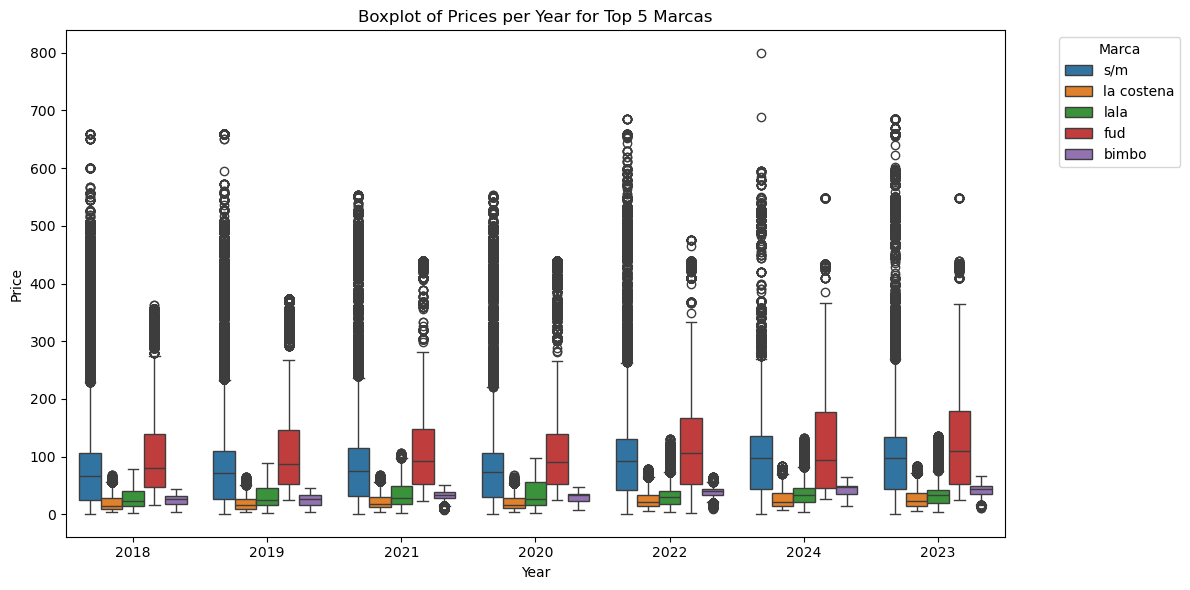

In [134]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_boxplot, x='anio', y='precio', hue='marca')
plt.title('Boxplot of Prices per Year for Top 5 Marcas')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(title='Marca', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Nota:** ¡¡¡Lo principal aqui es tu código de SQL para construir las tablas!!! Eso es lo que voy a calificar. R y Pandas, están ahi para que puedas gráficar y hacer tus tablas bonitas en el reporte, OJO no para sacar las estadísticas.

**Hint:** Guarda tus consultas en archivos que puedas guardar en S3 y luego leer desde Pandas o RStudio, para hacer tus gráficas o cuadros compartivos.